# Generative Adversarial Network Tutorial 00

In particle physics, we think adversarial networks are particularly interesting tools to explore discrepancies between our simulation and real detector data.  In principle, the physics tools used for simulation of particle interaction data are quite good, but they are never perfect.  Additionally, they are always imperfect in difficult to model ways.  Many experiments spend a lot of time studying the differences between the output of their simulation and their real detector data, and a deep network that can learn these differences is really useful for making progress.

In this tutorial, I'll cover some basics of generative adversarial networks with very simple feed-forward neural networks (not even convolutional) as a demonstration of the basic techniques of GANs.  You can read the original paper on GANs here: https://arxiv.org/abs/1406.2661.  The basic idea is you train two networks to compete with each other.  The first (called the discriminator) makes a decision on whether or not the images it's looking at are real or fake.  The second (called the generator) tries to generate fake images from random noise to fool the discriminator.

In the years since the original paper came out, GANs have grown increasinly more sophisticated and impressive, especially with the advent of the Deep Convolutional Generative Adversarial Network (DCGAN, original paper: https://arxiv.org/abs/1511.06434).  For this tutorial, we're going to eschew all of the recent advances to make a GAN that can generate artificial digits based on the mnist data set.  By stripping the networks down to their basics, it's easier to focus on the core aspects of the loss function and outputs, and to avoid the complications of training on GPUs, etc.

## MNIST data set

The mnist data set is one of the most famous collections of labeled images that exists.  You can read all about it at the original website (http://yann.lecun.com/exdb/mnist/), but it has a few nice advantages that make it ideal for learning:
 * It's open, and has convient wrappers in many languages (we'll use tensorflows soon)
 * It's a large data set (60k training images) but each image is small (28x28)
 * The data has been preprocessed to center images of digits and make them easier to use
 
Basically, you can focus on the fundamentals with this data set, which is why we'll use it here.  Some examples of loading it with tensorflow (more here: https://www.tensorflow.org/get_started/mnist/beginners)

In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0
import tensorflow as tf
import numpy
from tensorflow.examples.tutorials.mnist import input_data

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


With tensorflow, you can specify which device to use.  The next cell will tell you what's available, and you can select from there.  By default, I select "/gpu:0" but you can change this below

In [2]:
from tensorflow.python.client import device_lib
print device_lib.list_local_devices()
default_device = "/gpu:0"

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12913643054506099390
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 11946606592
locality {
  bus_id: 1
}
incarnation: 3262391229968045033
physical_device_desc: "device: 0, name: TITAN X (Pascal), pci bus id: 0000:01:00.0"
]


In [3]:
mnist = input_data.read_data_sets("MNIST_data", one_hot=False)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
mnist_images, mnist_labels = mnist.train.next_batch(batch_size=5)

Here, we've loaded the mnist data from the tensorflow helper class, and asked for the next batch of images and labels.  Let's view those to see what the data looks like before delving into the network:

In [5]:
print "mnist_images.shape: {}".format(mnist_images.shape)
print "mnist_labels.shape: {}".format(mnist_labels.shape)

mnist_images.shape: (5, 784)
mnist_labels.shape: (5,)


As expected, variables are arrays with the outermost dimension equal to 5.  The images, though, comes unpacked as a 1D array per image instead of a 2D array.  We can reshape this to what we're more familar with, since we know mnist images are 28x28:

In [6]:
mnist_images = numpy.reshape(mnist_images, (-1, 28, 28)) # -1 can be used as a placeholder for batch size here

In [7]:
print "mnist_images.shape: {}".format(mnist_images.shape)


mnist_images.shape: (5, 28, 28)


Matplotlib gives a good interface for viewing these images in a notebook (or even in general, in python):

In [8]:
from matplotlib import pyplot as plt
%matplotlib inline

This image is labeled as 8


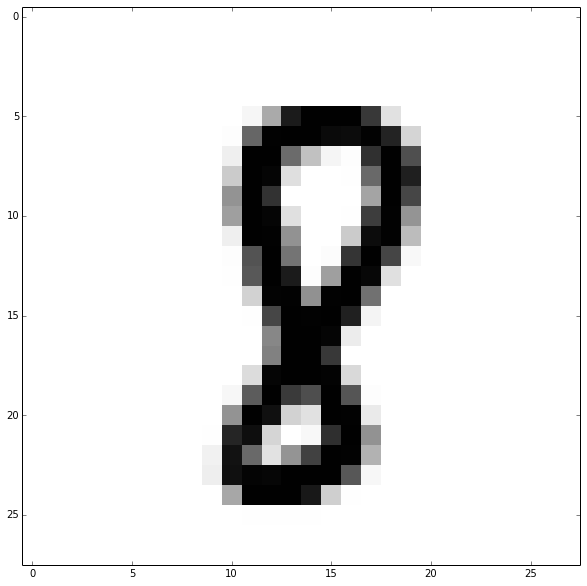

In [9]:
index = numpy.random.randint(5)
fig = plt.figure(figsize=(10,10))
plt.imshow(mnist_images[index], cmap="Greys", interpolation="none")
print "This image is labeled as {}".format(mnist_labels[index])
plt.show()

Drawn like this, you can see each individual pixel clearly.  It's not a high resolution image, but you can clearly tell what the digit is!

## Building a model for a GAN

We'll start to put together a network for the GAN, first by defining some useful constants that we'll need to call on multiple times:

In [10]:
BASE_LEARNING_RATE = 0.0002
BATCH_SIZE=50
RANDOM_INPUT_DIMENSIONALITY = 100
MAX_EPOCH=100
INCLUDE_NOISE=True
LOGDIR="./mnist_gan_logs/lr_{}_include_noise_{}_batchsize_{}".format(BASE_LEARNING_RATE, INCLUDE_NOISE, BATCH_SIZE)
RESTORE=False
TRAINING=True

Additionally, let's make sure we have the same graph by defining it:

In [11]:
tf.reset_default_graph()

g = tf.Graph()

Set up the placeholders for the input variables.  We'll need to input both real images and random noise, so make a placeholder for both.  Additionally, based on this blog post (http://www.inference.vc/instance-noise-a-trick-for-stabilising-gan-training/) I add random gaussian noise to the real and fake images as they are fed to the discriminator to help stabalize training.

In [12]:
with tf.device(default_device):
    with g.as_default():
        # Input noise to the generator:
        noise_tensor = tf.placeholder(tf.float32, [BATCH_SIZE, RANDOM_INPUT_DIMENSIONALITY], name="noise")
#         fake_input   = tf.reshape(noise_tensor, (tf.shape(noise_tensor)[0], 10,10, 1))

        # Placeholder for the discriminator input:
        real_flat  = tf.placeholder(tf.float32, [BATCH_SIZE, 784], name='x')

        # We augment the input to the discriminator with gaussian noise
        # This makes it harder for the discriminator to do it's job, preventing
        # it from always "winning" the GAN min/max contest
        real_noise = tf.placeholder(tf.float32, [BATCH_SIZE, 28*28], name="real_noise")
        fake_noise = tf.placeholder(tf.float32, [BATCH_SIZE, 28*28], name="fake_noise")

        real_images = real_flat + real_noise


Notice how the input tensors (noise_tensor, real_images) are shaped in the 'flattened' way: (N/2, 100) for noise, (N/2, 784) for real images.  This lets me input the mnist images directly to tensorflow, as well as the noise.  They are then reshaped to be like tensorflow images (Batch, H, W, Filters).

### Image Discriminator:

Make a function to build the discriminator, using fully connected networks.  Note that a convolutional layer with the stride equal to the image size *is* a fully connected layer.

In [13]:
def build_discriminator(input_tensor, reuse, is_training, reg=0.2, dropout_rate=0.3):
    # Use scoping to keep the variables nicely organized in the graph.
    # Scoping is good practice always, but it's *essential* here as we'll see later on
    with tf.variable_scope("mnist_discriminator", reuse=reuse):

        x = tf.layers.dense(input_tensor, 512, name="fc1")
        
        # Apply a non linearity:
        x = tf.maximum(reg*x, x, name="leaky_relu_1")
        
        # Apply a dropout layer:
        x = tf.layers.dropout(x,rate=dropout_rate, training=is_training, name="dropout1")

        x = tf.layers.dense(x, 256, name="fc2")
        
        # Apply a non linearity:
        x = tf.maximum(reg*x, x, name="leaky_relu_2")
        
        # Apply a dropout layer:
        x = tf.layers.dropout(x,rate=dropout_rate, training=is_training, name="dropout2")
        
        x = tf.layers.dense(x, 1, name="fc4") 
    
        # Since we want to predict "real" or "fake", an output of 0 or 1 is desired.  sigmoid is perfect for this:
        x = tf.nn.sigmoid(x, name="discriminator_sigmoid")

        return x

In [14]:
with tf.device(default_device):
    with g.as_default():
        real_image_logits = build_discriminator(real_images, reuse=False,is_training=TRAINING, reg=0.2, dropout_rate=0.3)

Now we can define a function to generate random images from noise:

In [15]:
def build_generator(input_tensor, reg=0.2):
    # Again, scoping is essential here:
    with tf.variable_scope("mnist_generator"):
        x = tf.layers.dense(input_tensor, 256, name="fc1")
        
        # Apply a non linearity:
        x = tf.maximum(reg*x, x, name="leaky_relu_1")
        
        x = tf.layers.dense(x, 512, name="fc2")
        
        # Apply a non linearity:
        x = tf.maximum(reg*x, x, name="leaky_relu_2")
        
        x = tf.layers.dense(x, 1024, name="fc3")
        
        # Apply a non linearity:
        x = tf.maximum(reg*x, x, name="leaky_relu_3")
        
        x = tf.layers.dense(x, 28*28, name="fc4")
        

        # Reshape to match mnist images:
#         x = tf.reshape(x, (-1, 28, 28, 1))
        
        # The final non linearity applied here is to map the images onto the [-1,1] range.
        x = tf.nn.tanh(x, name="generator_tanh")
        return x

In [16]:
with tf.device(default_device):
    with g.as_default():
        fake_images = build_generator(noise_tensor) + fake_noise

We also need to be able to run the discriminator on the fake images, so set that up too.  Since it trains on both real and fake images, set reuse=True here:

In [17]:
with tf.device(default_device):
    with g.as_default():
        fake_image_logits = build_discriminator(fake_images, reuse=True, is_training=TRAINING, dropout_rate=0.3, reg=0.2)

### Loss functions

We can now define our loss functions.  Note that we have to define the loss function for the generator and discriminator seperately:

In [18]:
with tf.device(default_device):
    # Build the loss functions:
    with g.as_default():
        with tf.name_scope("cross_entropy") as scope:

            # Be careful with the loss functions.  The sigmoid activation is already applied as the
            # last step of the discriminator network above.  If you want to use something like 
            # tf.nn.sigmoid_cross_entropy_with_loss, it *will not train* because it applies 
            # a sigmoid a second time.
            d_loss_total = -tf.reduce_mean(tf.log(real_image_logits) + tf.log(1. - fake_image_logits))
            
        
            # This is the adverserial step: g_loss tries to optimize fake_logits to one,
            # While d_loss_fake tries to optimize fake_logits to zero.
            g_loss = -tf.reduce_mean(tf.log(fake_image_logits))

            # This code is useful if you'll use tensorboard to monitor training:
#             d_loss_summary = tf.summary.scalar("Discriminator_Real_Loss", d_loss_real)
#             d_loss_summary = tf.summary.scalar("Discriminator_Fake_Loss", d_loss_fake)
            d_loss_summary = tf.summary.scalar("Discriminator_Total_Loss", d_loss_total)
            d_loss_summary = tf.summary.scalar("Generator_Loss", g_loss)


It's also useful to compute accuracy, just to see how the training is going:

In [19]:
with tf.device(default_device):
    with g.as_default():
        with tf.name_scope("accuracy") as scope:
            # Compute the discriminator accuracy on real data, fake data, and total:
            accuracy_real  = tf.reduce_mean(tf.cast(tf.equal(tf.round(real_image_logits), 
                                                             tf.ones_like(real_image_logits)), 
                                                    tf.float32))
            accuracy_fake  = tf.reduce_mean(tf.cast(tf.equal(tf.round(fake_image_logits), 
                                                             tf.zeros_like(fake_image_logits)), 
                                                    tf.float32))

            total_accuracy = 0.5*(accuracy_fake +  accuracy_real)

            # Again, useful for tensorboard:
            acc_real_summary = tf.summary.scalar("Real_Accuracy", accuracy_real)
            acc_real_summary = tf.summary.scalar("Fake_Accuracy", accuracy_fake)
            acc_real_summary = tf.summary.scalar("Total_Accuracy", total_accuracy)

### Independant Optimizers

To allow the generator and discriminator to compete and update seperately, we use two distinct optimizers.  This step is why it was essential earlier to have the scopes different for the generator and optimizer: we can select all variables in each scope to go to their own optimizer.  So, even though the generator loss calculation runs the discriminator, the update step for the generator **only** affects the variables inside the generator

In [20]:
with tf.device(default_device):
    with g.as_default():
        with tf.name_scope("training") as scope:
            # Global steps are useful for restoring training:
            global_step = tf.Variable(0, dtype=tf.int32, trainable=False, name='global_step')

            # Make sure the optimizers are only operating on their own variables:

            all_variables      = tf.trainable_variables()
            discriminator_vars = [v for v in all_variables if v.name.startswith('mnist_discriminator/')]
            generator_vars     = [v for v in all_variables if v.name.startswith('mnist_generator/')]


            discriminator_optimizer = tf.train.AdamOptimizer(BASE_LEARNING_RATE, 0.5).minimize(
                d_loss_total, global_step=global_step, var_list=discriminator_vars)
            generator_optimizer     = tf.train.AdamOptimizer(BASE_LEARNING_RATE, 0.5).minimize(
                g_loss, global_step=global_step, var_list=generator_vars)


### Image snapshots

It's useful to snapshot images into tensorboard to see how things are going, as well:

In [21]:
with tf.device(default_device):
    with g.as_default():
        # Reshape images for snapshotting:
        fake_images_reshaped = tf.reshape(fake_images, (-1, 28, 28, 1))
        real_images_reshaped = tf.reshape(real_images, (-1, 28, 28, 1))
        tf.summary.image('fake_images', fake_images_reshaped, max_outputs=4)
        tf.summary.image('real_images', real_images_reshaped, max_outputs=4)


## Training the networks

There are lots of philosophys on training GANs.  Here, we'll do something simple and just alternate updates. To save the network and keep track of training variables, set up a summary writer:

In [22]:
with tf.device(default_device):
    with g.as_default():
        merged_summary = tf.summary.merge_all()

        # Set up a saver:
        train_writer = tf.summary.FileWriter(LOGDIR)

Before we start training in earnest, let's make some storage for images as a function of epochs, etc.  This network will also store loss and accuracy as a function of epoch so we can make some plots after training is done.

In [23]:
epochs   = [] # store the epoch corresponding to the variables below
gen_loss = []
dis_loss = []
images   = []
true_acc = []
fake_acc = []
tot_acc  = []


Set up a session for training using an interactive session:

In [24]:
with tf.device(default_device):
    with g.as_default():
        sess = tf.InteractiveSession()
        if not RESTORE:
            sess.run(tf.global_variables_initializer())
            train_writer.add_graph(sess.graph)
            saver = tf.train.Saver()
        else: 
            latest_checkpoint = tf.train.latest_checkpoint(LOGDIR+"/checkpoints/")
            print "Restoring model from {}".format(latest_checkpoint)
            saver = tf.train.Saver()
            saver.restore(sess, latest_checkpoint)



        print "Begin training ..."
        # Run training loop
        for i in xrange(50000000):
            step = sess.run(global_step)

            # Receive data (this will hang if IO thread is still running = this
            # will wait for thread to finish & receive data)
            epoch = (1.0*i*BATCH_SIZE) / 60000.
            if (epoch > MAX_EPOCH):
                break
            sigma = max(0.75*(10. - epoch) / (10), 0.05)
            
            # Update the generator:
            # Prepare the input to the networks:
            fake_input = numpy.random.normal(loc=0, scale=1, size=(BATCH_SIZE, RANDOM_INPUT_DIMENSIONALITY))
            real_data, label = mnist.train.next_batch(BATCH_SIZE)
            real_data = 2*(real_data - 0.5)
            if INCLUDE_NOISE:
                real_noise_addition = numpy.random.normal(scale=sigma,size=(BATCH_SIZE,28*28))
                fake_noise_addition = numpy.random.normal(scale=sigma,size=(BATCH_SIZE,28*28))
            else:
                real_noise_addition = numpy.zeros((BATCH_SIZE, 28*28))
                fake_noise_addition = numpy.zeros((BATCH_SIZE, 28*28))

            # Update the discriminator:
            [generated_mnist, _] = sess.run([fake_images, 
                                            discriminator_optimizer], 
                                            feed_dict = {noise_tensor : fake_input,
                                                         real_flat : real_data,
                                                         real_noise: real_noise_addition,
                                                         fake_noise: fake_noise_addition})

            # Update the generator:
            fake_input = numpy.random.normal(loc=0, scale=1, size=(BATCH_SIZE, RANDOM_INPUT_DIMENSIONALITY))
            if INCLUDE_NOISE:
                fake_noise_addition = numpy.random.normal(scale=sigma,size=(BATCH_SIZE,28*28))
            else:
                fake_noise_addition = numpy.zeros((BATCH_SIZE, 28*28))

            
            [ _ ] = sess.run([generator_optimizer], 
                feed_dict = {noise_tensor: fake_input,
                             real_flat : real_data,
                             real_noise: real_noise_addition,
                             fake_noise: fake_noise_addition})
            
            # Run a summary step:
            [summary, g_l, d_l, acc_fake, acc_real, acc] = sess.run(
                [merged_summary, g_loss, d_loss_total, accuracy_fake, accuracy_real, total_accuracy],
                feed_dict = {noise_tensor : fake_input,
                             real_flat : real_data,
                             real_noise: real_noise_addition,
                             fake_noise: fake_noise_addition})


            train_writer.add_summary(summary, step)


            if step != 0 and step % 500 == 0:
                saver.save(
                    sess,
                    LOGDIR+"/checkpoints/save",
                    global_step=step)


            # train_writer.add_summary(summary, i)
            # sys.stdout.write('Training in progress @ step %d\n' % (step))
            if i != 0 and int(10*epoch) == 10*epoch:
                if int(epoch) == epoch:
                    print 'Training in progress @ epoch %g, g_loss %g, d_loss %g accuracy %g' % (epoch, g_l, d_l, acc)
                epochs.append(epoch)
                gen_loss.append(g_l)
                dis_loss.append(d_l)
                images.append(generated_mnist)
                true_acc.append(acc_real)
                fake_acc.append(acc_fake)
                tot_acc.append(acc)

Begin training ...
Training in progress @ epoch 1, g_loss 1.01972, d_loss 1.05898 accuracy 0.72
Training in progress @ epoch 2, g_loss 0.807037, d_loss 1.38513 accuracy 0.59
Training in progress @ epoch 3, g_loss 0.946898, d_loss 1.12282 accuracy 0.71
Training in progress @ epoch 4, g_loss 1.05892, d_loss 1.1675 accuracy 0.7
Training in progress @ epoch 5, g_loss 0.872296, d_loss 1.3347 accuracy 0.56
Training in progress @ epoch 6, g_loss 0.781431, d_loss 1.35542 accuracy 0.52
Training in progress @ epoch 7, g_loss 0.901021, d_loss 1.17788 accuracy 0.7
Training in progress @ epoch 8, g_loss 0.88955, d_loss 1.25929 accuracy 0.7
Training in progress @ epoch 9, g_loss 0.739947, d_loss 1.3106 accuracy 0.61
Training in progress @ epoch 10, g_loss 0.775415, d_loss 1.32019 accuracy 0.58
Training in progress @ epoch 11, g_loss 0.831139, d_loss 1.26377 accuracy 0.63
Training in progress @ epoch 12, g_loss 0.677379, d_loss 1.36963 accuracy 0.57
Training in progress @ epoch 13, g_loss 0.731501, d

[NOTE: I  cleared the output of the training to make the notebook easier to read online.  It trained for about 350 epochs, which is quite awhile.  It turned in to several hours on a GPU.]

### Plotting training variables

To confirm the training went well, we can look at the variables we saved:

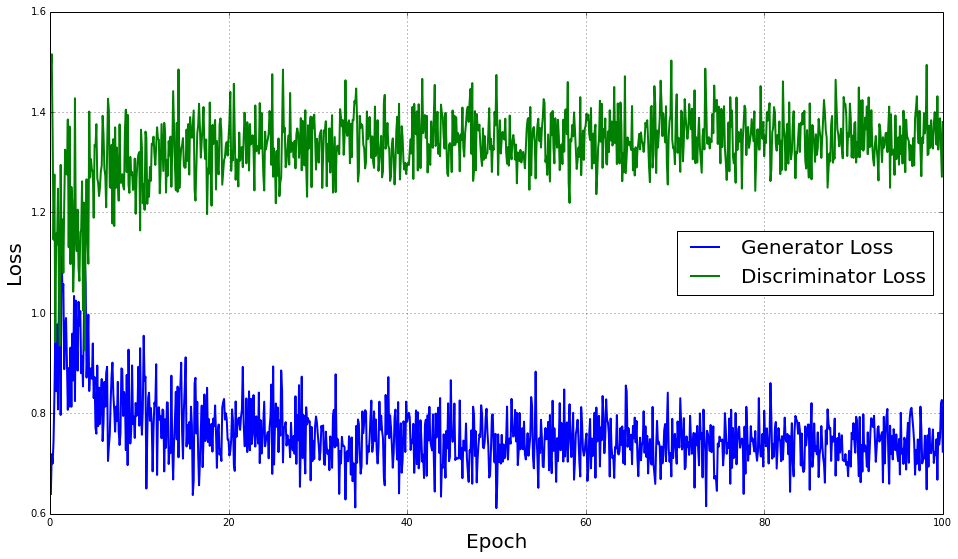

In [25]:
# Plot the loss values:
fig = plt.figure(figsize=(16,9))
plt.plot(epochs, gen_loss, label="Generator Loss", lw=2)
plt.plot(epochs, dis_loss, label="Discriminator Loss", lw=2)
plt.grid(True)
plt.xlabel("Epoch", fontsize=20)
plt.ylabel("Loss",  fontsize=20)
plt.legend(fontsize=20, loc='best')
plt.show()

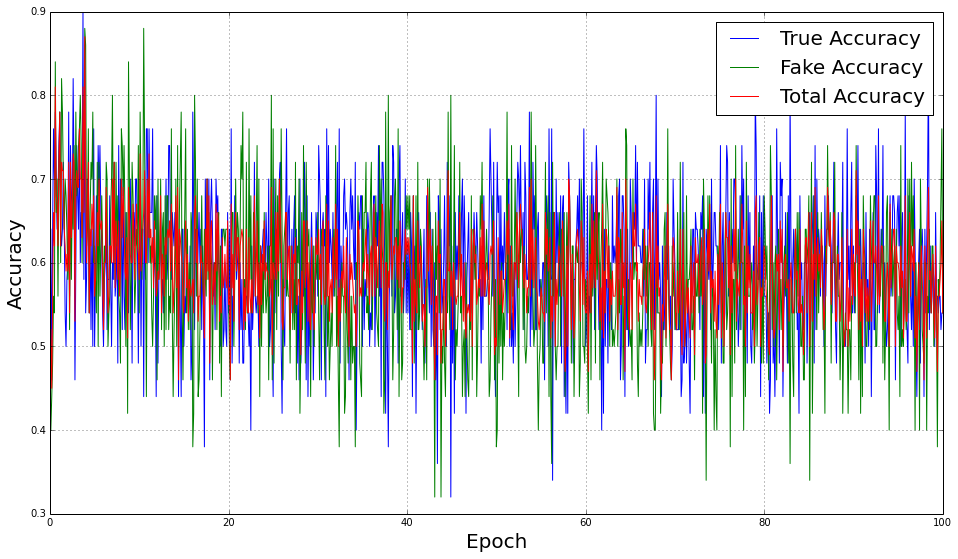

In [26]:
# Plot the accuracy values:
fig = plt.figure(figsize=(16,9))
plt.plot(epochs, true_acc, label="True Accuracy", lw=1)
plt.plot(epochs, fake_acc, label="Fake Accuracy", lw=1)
plt.plot(epochs, tot_acc, label="Total Accuracy", lw=1)
plt.grid(True)
plt.xlabel("Epoch", fontsize=20)
plt.ylabel("Accuracy",  fontsize=20)
plt.legend(fontsize=20, loc='best')
plt.show()

The loss and accuracy graphs indicate the training went pretty well,  Over time, the generator got better at tricking the discriminator (you can see the generator loss decreasing and discriminator loss increasing).  Additionally, the accuracy trended towards 50% for both real and fake data.  In badly trained examples, the average accuracy might be 50% but the individual accuracys (fake or real) are 0 or 100%, indicating the network isn't learning well.

### Image Progression

We can see the images progress over time.  I'll show the progression over the epochs, and we can see a large sample images below that are generated from the network as it's read back at inference time.

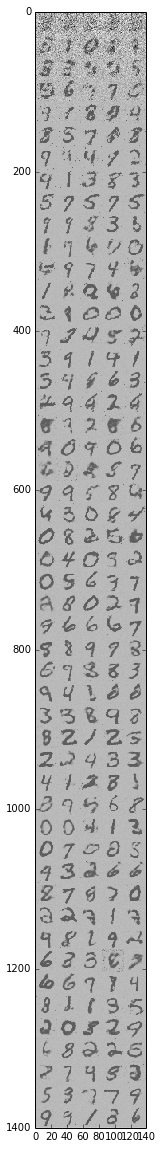

In [31]:
indexes = range(len(epochs))[::20]
image_array = numpy.zeros((28*len(indexes), 5*28))
for i, e in enumerate(indexes):
    image_set = images[e]
    for j in xrange(5):
        index = numpy.random.randint(len(image_set))
        image_array[i*28:(i+1)*28, j*28:(j+1)*28].shape
        image_array[i*28:(i+1)*28, j*28:(j+1)*28] = image_set[index].reshape(28,28)
      
fig = plt.figure(figsize=(20,20))
plt.imshow(image_array, cmap="Greys", interpolation="none")
plt.show()
        

In the above, we can see the epochs progressing (downward) and the images improving from noise to recognizable digits.

As a last step, let's load this network back into memory and generate a few fake images for visualization.  As you'll see, this network does "OK" but not amazingly well.  In the next post, we'll see a deep convolutional network that does better at generating images.

In [28]:
tf.reset_default_graph()
with tf.device(default_device):
    g = tf.Graph()
    with g.as_default():
        sess = tf.InteractiveSession()
        latest_checkpoint = tf.train.latest_checkpoint(LOGDIR+"/checkpoints/")
        print "Restoring model from {}".format(latest_checkpoint)
        
        noise_tensor = tf.placeholder(tf.float32, [BATCH_SIZE, RANDOM_INPUT_DIMENSIONALITY], name="noise")

        fake_noise = tf.placeholder(tf.float32, [BATCH_SIZE, 28*28], name="fake_noise")

        fake_images = build_generator(noise_tensor) + fake_noise
        
        
        saver = tf.train.Saver()
        saver.restore(sess, latest_checkpoint)

        # We only need to make fake data and run it through the 'fake_images' tensor to see the output:
        
        fake_input = numpy.random.normal(loc=0, scale=1, size=(BATCH_SIZE, RANDOM_INPUT_DIMENSIONALITY))
        fake_noise_addition = numpy.zeros((BATCH_SIZE, 28*28))
        [generated_images] = sess.run(
                [fake_images], 
                feed_dict = {noise_tensor : fake_input,
                             fake_noise : fake_noise_addition})


Restoring model from ./mnist_gan_logs/lr_0.0002_include_noise_True_batchsize_50/checkpoints/save-240000
INFO:tensorflow:Restoring parameters from ./mnist_gan_logs/lr_0.0002_include_noise_True_batchsize_50/checkpoints/save-240000


Reshape to make it easier to draw:

In [29]:
generated_images = numpy.reshape(generated_images, (-1, 28, 28))

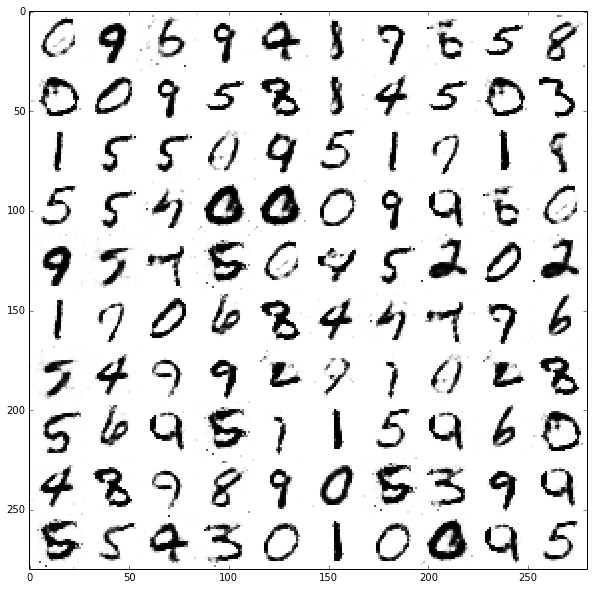

In [30]:
# Tile together lots of digits to see how the network is doing:
final_image = numpy.zeros((280, 280))
for i in range(10):
    for j in range(10):
        index = numpy.random.randint(BATCH_SIZE)
        final_image[i*28:(i+1)*28, j*28:(j+1)*28] = generated_images[index].reshape(28, 28)
        
fig = plt.figure(figsize=(10,10))
plt.imshow(final_image, cmap="Greys", interpolation="none")
plt.show()

Well ... It's OK.  Some of them look like real digits!  Others are less convincing.  But, this at least demonstrates the basics of generative adversarial networks.